In [16]:
# Q2 part A
import torch
import torchvision
from torchvision.models.segmentation import fcn_resnet50
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


model = fcn_resnet50(weights="DEFAULT")
model.eval()

voc_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
voc_target_transform = torchvision.transforms.PILToTensor()


dataset = torchvision.datasets.VOCSegmentation(
    root='./data', year='2012', image_set='val', download=True,
    transform=voc_transform,
    target_transform=voc_target_transform
)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

def compute_metrics(model, loader, num_images=10):
    total_pixel_acc = 0
    total_miou = 0
    for i, (img, target) in enumerate(loader):
        if i >= num_images:
            break
        img = img.to(torch.float32)
        target = target.squeeze(1).long()

        output = model(img)['out']
        pred = output.argmax(1)

        if pred.shape != target.shape:
            target = torch.nn.functional.interpolate(target.unsqueeze(1).float(),
                                                     size=pred.shape[1:],
                                                     mode='nearest').long().squeeze(1)

        correct = (pred == target).sum().item()
        total_pixel_acc += correct / target.numel()

        iou_per_class = []
        for cls in range(21):
            intersection = ((pred == cls) & (target == cls)).sum().float()
            union = ((pred == cls) | (target == cls)).sum().float()
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_per_class.append(iou.item())
        total_miou += np.mean(iou_per_class)

    return {'pixel_acc': total_pixel_acc / num_images, 'miou': total_miou / num_images}

# 10 validation images
metrics = compute_metrics(model, loader)
print("FCN ResNet50 Metrics:", metrics)

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 136MB/s]


100%|██████████| 2.00G/2.00G [01:22<00:00, 24.4MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
FCN ResNet50 Metrics: {'pixel_acc': 0.9018546021039804, 'miou': 0.946459339441942}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
import os
from PIL import Image


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


dataset_folder = "dataset"

with open(os.path.join(dataset_folder, "label2cmap.json"), "r") as f:
    label2cmap = json.load(f)
    cmap2label = {tuple(v): idx for idx, (k, v) in enumerate(label2cmap.items())}

num_classes = len(cmap2label)

with open(os.path.join(dataset_folder, "train_test_split.json"), "r") as f:
    split_data = json.load(f)
    train_files = split_data["train"]
    test_files = split_data["test"]


class RandomHorizontalFlipResize:
    def __init__(self, size=(256,256), p=0.5):
        self.size = size
        self.p = p
    def __call__(self, img, mask):
        img = img.resize(self.size, resample=Image.BILINEAR)
        mask = mask.resize(self.size, resample=Image.NEAREST)
        if np.random.rand() < self.p:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

transform = RandomHorizontalFlipResize(size=(256,256), p=0.5)
to_tensor = transforms.ToTensor()

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, label2cmap, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.label2cmap = label2cmap
        # Build cmap2label mapping
        self.cmap2label = {tuple(v): idx for idx, (k, v) in enumerate(self.label2cmap.items())}
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        image_path = os.path.join(self.image_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        if self.transform:
            image, mask = self.transform(image, mask)

        image = to_tensor(image)
        mask_np = np.array(mask)
        mask_label = np.full((mask_np.shape[0], mask_np.shape[1]), 0, dtype=np.int64)
        for rgb, label in self.cmap2label.items():
            mask_label[(mask_np == rgb).all(axis=-1)] = label
        mask_tensor = torch.from_numpy(mask_label).long()
        return image, mask_tensor

image_dir = os.path.join(dataset_folder, "images")
mask_dir  = os.path.join(dataset_folder, "masks")

train_dataset = SegmentationDataset(image_dir, mask_dir, train_files, label2cmap, transform=transform)
test_dataset  = SegmentationDataset(image_dir, mask_dir, test_files, label2cmap, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FCN16s(nn.Module):
    def __init__(self, num_classes):
        super(FCN16s, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes,
                                           kernel_size=4, stride=2,
                                           padding=1, bias=False)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes,
                                            kernel_size=32, stride=16,
                                            padding=8, bias=False)
        self._initialize_weights()

    def _initialize_weights(self):
        weight2 = self.get_upsampling_weight(self.upscore2.in_channels,
                                             self.upscore2.out_channels,
                                             self.upscore2.kernel_size[0])
        self.upscore2.weight.data.copy_(weight2)
        weight16 = self.get_upsampling_weight(self.upscore16.in_channels,
                                              self.upscore16.out_channels,
                                              self.upscore16.kernel_size[0])
        self.upscore16.weight.data.copy_(weight16)

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        center = factor - 1 if kernel_size % 2 == 1 else factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
        for i in range(in_channels):
            for j in range(out_channels):
                if i == j:
                    weight[i, j, :, :] = filt
        return torch.from_numpy(weight).float()

    def forward(self, x):
        pool4 = None
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 23:
                pool4 = x
        score_fr = self.score_fr(x)
        upscore2 = self.upscore2(score_fr)
        score_pool4 = self.score_pool4(pool4)
        fuse = upscore2 + score_pool4
        out = self.upscore16(fuse)
        return out

model_fcn16s = FCN16s(num_classes).to(device)
optimizer16s = optim.Adam(model_fcn16s.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

#learning rate scheduler to reduce the LR every 10 epochs by 0.1x
scheduler = optim.lr_scheduler.StepLR(optimizer16s, step_size=10, gamma=0.1)


def train_model(model, loader, criterion, optimizer, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def mean_iou(outputs, masks, num_classes):
    preds = torch.argmax(outputs, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_model(model, loader, num_classes):
    model.eval()
    total_correct = 0
    total_pixels = 0
    iou_list = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
            iou_list.append(mean_iou(outputs, masks, num_classes))
    pix_acc = total_correct / total_pixels
    mean_iou_score = np.mean(iou_list)
    print(f"Pixel Accuracy: {pix_acc*100:.2f}%, Mean IOU: {mean_iou_score*100:.2f}%")


print("Training FCN-16s (VGG16) with data augmentation and LR scheduling...")
train_model(model_fcn16s, train_loader, criterion, optimizer16s, scheduler, epochs=20)

print("Evaluating FCN-16s on test set:")
evaluate_model(model_fcn16s, test_loader, num_classes)


Training FCN-16s (VGG16) with data augmentation and LR scheduling...
Epoch [1/20], Loss: 0.3723
Epoch [2/20], Loss: 0.2500
Epoch [3/20], Loss: 0.1869
Epoch [4/20], Loss: 0.1558
Epoch [5/20], Loss: 0.1408
Epoch [6/20], Loss: 0.1395
Epoch [7/20], Loss: 0.1210
Epoch [8/20], Loss: 0.1595
Epoch [9/20], Loss: 0.1235
Epoch [10/20], Loss: 0.1828
Epoch [11/20], Loss: 0.1139
Epoch [12/20], Loss: 0.1008
Epoch [13/20], Loss: 0.0964
Epoch [14/20], Loss: 0.0934
Epoch [15/20], Loss: 0.0888
Epoch [16/20], Loss: 0.0864
Epoch [17/20], Loss: 0.0844
Epoch [18/20], Loss: 0.0897
Epoch [19/20], Loss: 0.0811
Epoch [20/20], Loss: 0.0798
Evaluating FCN-16s on test set:
Pixel Accuracy: 96.36%, Mean IOU: 37.04%


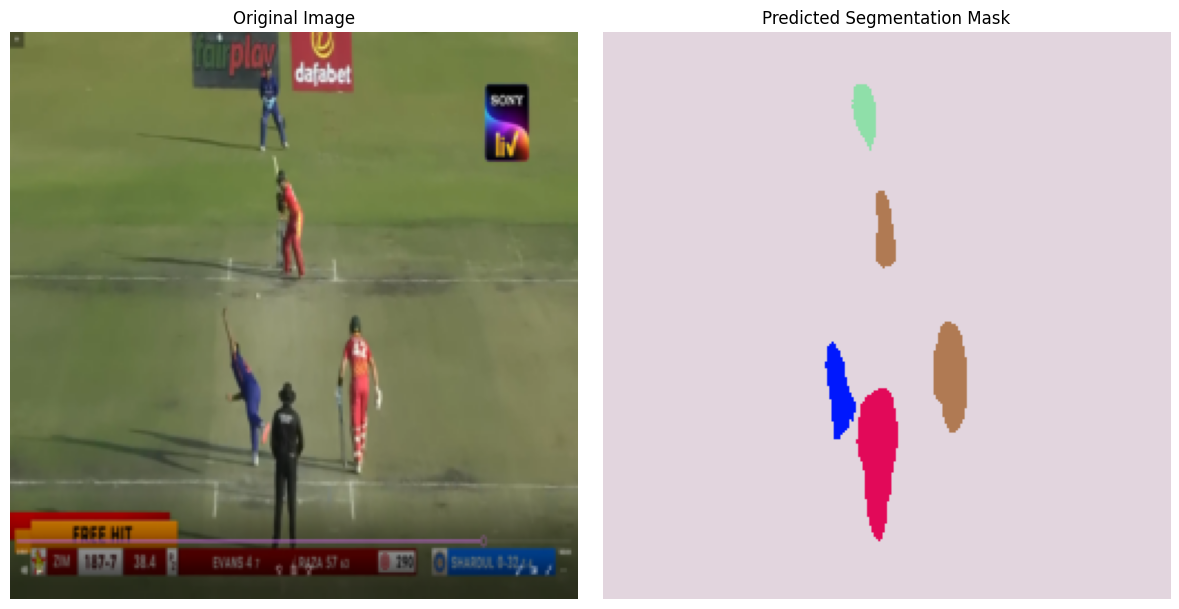

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_plot(image_path, model, cmap2label, device, size=(256,256)):
    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize(size, resample=Image.BILINEAR)

    transform_to_tensor = transforms.ToTensor()
    image_tensor = transform_to_tensor(image_resized)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    idx_to_color = {v: k for k, v in cmap2label.items()}

    H, W = pred.shape
    color_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for label in np.unique(pred):
        color_mask[pred == label] = np.array(idx_to_color.get(label, (0, 0, 0)))

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image_resized)
    axs[0].set_title("Original Image")
    axs[0].axis("off")

    axs[1].imshow(color_mask)
    axs[1].set_title("Predicted Segmentation Mask")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

predict_and_plot("dataset/images/2022-08-24 (300).png", model_fcn16s, cmap2label, device)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
import os
from PIL import Image

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"



dataset_folder = "dataset"

with open(os.path.join(dataset_folder, "label2cmap.json"), "r") as f:
    label2cmap = json.load(f)
    cmap2label = {tuple(v): idx for idx, (k, v) in enumerate(label2cmap.items())}

num_classes = len(cmap2label)

with open(os.path.join(dataset_folder, "train_test_split.json"), "r") as f:
    split_data = json.load(f)
    train_files = split_data["train"]
    test_files = split_data["test"]

class RandomHorizontalFlipResize:
    def __init__(self, size=(256,256), p=0.5):
        self.size = size
        self.p = p
    def __call__(self, img, mask):
        img = img.resize(self.size, resample=Image.BILINEAR)
        mask = mask.resize(self.size, resample=Image.NEAREST)
        if np.random.rand() < self.p:
            img = img.transpose(Image.FLIP_LEFT_RIGHT)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        return img, mask

transform = RandomHorizontalFlipResize(size=(256,256), p=0.5)
to_tensor = transforms.ToTensor()

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, file_list, label2cmap, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.file_list = file_list
        self.label2cmap = label2cmap
        self.cmap2label = {tuple(v): idx for idx, (k, v) in enumerate(self.label2cmap.items())}
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        image_path = os.path.join(self.image_dir, file_name)
        mask_path = os.path.join(self.mask_dir, file_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        if self.transform:
            image, mask = self.transform(image, mask)

        image = to_tensor(image)
        mask_np = np.array(mask)
        mask_label = np.full((mask_np.shape[0], mask_np.shape[1]), 0, dtype=np.int64)
        for rgb, label in self.cmap2label.items():
            mask_label[(mask_np == rgb).all(axis=-1)] = label
        mask_tensor = torch.from_numpy(mask_label).long()
        return image, mask_tensor

image_dir = os.path.join(dataset_folder, "images")
mask_dir  = os.path.join(dataset_folder, "masks")

train_dataset = SegmentationDataset(image_dir, mask_dir, train_files, label2cmap, transform=transform)
test_dataset  = SegmentationDataset(image_dir, mask_dir, test_files, label2cmap, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class FCN32s(nn.Module):
    def __init__(self, num_classes):
        super(FCN32s, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.features = vgg.features
        self.score_fr = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upscore = nn.ConvTranspose2d(num_classes, num_classes,
                                          kernel_size=64, stride=32,
                                          padding=16, bias=False)
        self._initialize_weights()

    def _initialize_weights(self):
        weight = self.get_upsampling_weight(self.upscore.in_channels,
                                            self.upscore.out_channels,
                                            self.upscore.kernel_size[0])
        self.upscore.weight.data.copy_(weight)

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        center = factor - 1 if kernel_size % 2 == 1 else factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype=np.float64)
        for i in range(in_channels):
            for j in range(out_channels):
                if i == j:
                    weight[i, j, :, :] = filt
        return torch.from_numpy(weight).float()

    def forward(self, x):
        x = self.features(x)
        x = self.score_fr(x)
        x = self.upscore(x)
        return x

model_fcn32s = FCN32s(num_classes).to(device)



optimizer32s = optim.Adam(model_fcn32s.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer32s, step_size=10, gamma=0.1)

def train_model(model, loader, criterion, optimizer, scheduler, epochs=30):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        scheduler.step()
        avg_loss = epoch_loss / len(loader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

def mean_iou(outputs, masks, num_classes):
    preds = torch.argmax(outputs, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (masks == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            continue
        ious.append(intersection / union)
    return np.mean(ious) if ious else 0

def evaluate_model(model, loader, num_classes):
    model.eval()
    total_correct = 0
    total_pixels = 0
    iou_list = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if masks.dim() == 4 and masks.shape[1] == 1:
                masks = masks.squeeze(1)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            total_correct += (preds == masks).sum().item()
            total_pixels += masks.numel()
            iou_list.append(mean_iou(outputs, masks, num_classes))
    pix_acc = total_correct / total_pixels
    mean_iou_score = np.mean(iou_list)
    print(f"Pixel Accuracy: {pix_acc*100:.2f}%, Mean IOU: {mean_iou_score*100:.2f}%")

print("Training FCN-32s (VGG16) for 30 epochs ...")
train_model(model_fcn32s, train_loader, criterion, optimizer32s, scheduler, epochs=30)

print("Evaluating FCN-32s on test set:")
evaluate_model(model_fcn32s, test_loader, num_classes)


Training FCN-32s (VGG16) for 30 epochs ...
Epoch [1/30], Loss: 0.7544
Epoch [2/30], Loss: 0.2694
Epoch [3/30], Loss: 0.2452
Epoch [4/30], Loss: 0.2185
Epoch [5/30], Loss: 0.2283
Epoch [6/30], Loss: 0.2031
Epoch [7/30], Loss: 0.1888
Epoch [8/30], Loss: 0.1740
Epoch [9/30], Loss: 0.1667
Epoch [10/30], Loss: 0.1536
Epoch [11/30], Loss: 0.1282
Epoch [12/30], Loss: 0.1244
Epoch [13/30], Loss: 0.1193
Epoch [14/30], Loss: 0.1157
Epoch [15/30], Loss: 0.1135
Epoch [16/30], Loss: 0.1106
Epoch [17/30], Loss: 0.1102
Epoch [18/30], Loss: 0.1071
Epoch [19/30], Loss: 0.1058
Epoch [20/30], Loss: 0.1027
Epoch [21/30], Loss: 0.0994
Epoch [22/30], Loss: 0.0985
Epoch [23/30], Loss: 0.0983
Epoch [24/30], Loss: 0.0981
Epoch [25/30], Loss: 0.0984
Epoch [26/30], Loss: 0.0975
Epoch [27/30], Loss: 0.0976
Epoch [28/30], Loss: 0.0976
Epoch [29/30], Loss: 0.0969
Epoch [30/30], Loss: 0.0968
Evaluating FCN-32s on test set:
Pixel Accuracy: 95.53%, Mean IOU: 30.66%


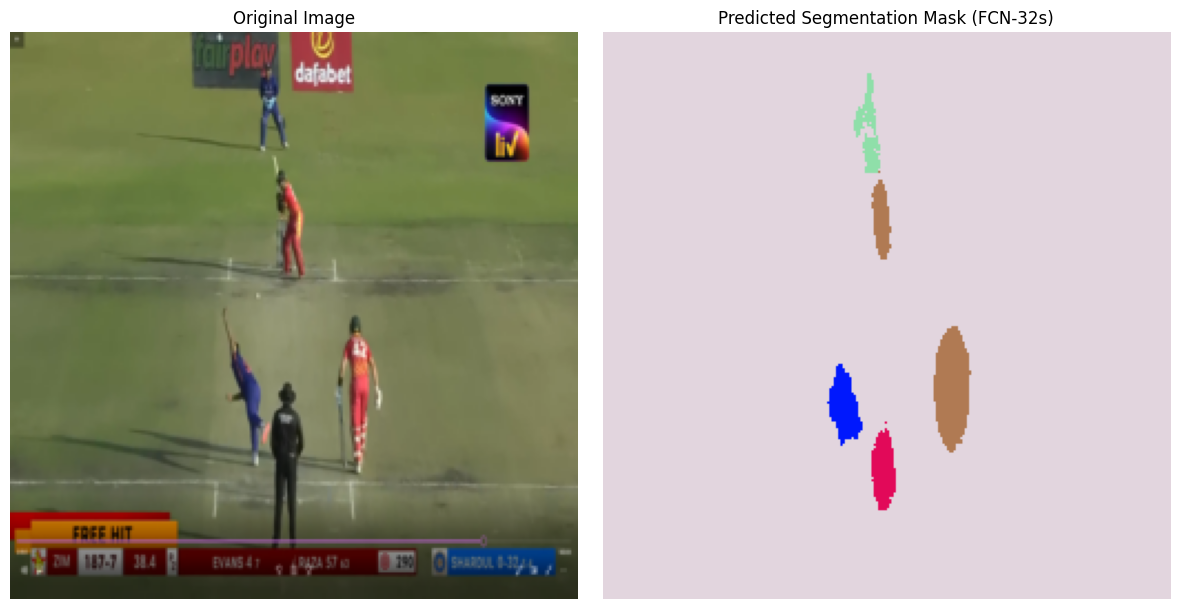

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_plot_fcn32s(image_path, model, cmap2label, device, size=(256,256)):
    image = Image.open(image_path).convert("RGB")
    image_resized = image.resize(size, resample=Image.BILINEAR)

    transform_to_tensor = transforms.ToTensor()
    image_tensor = transform_to_tensor(image_resized)
    input_tensor = image_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    idx_to_color = {v: k for k, v in cmap2label.items()}

    H, W = pred.shape
    color_mask = np.zeros((H, W, 3), dtype=np.uint8)
    for label in np.unique(pred):
        color_mask[pred == label] = np.array(idx_to_color.get(label, (0,0,0)))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image_resized)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(color_mask)
    axes[1].set_title("Predicted Segmentation Mask (FCN-32s)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


# Update the path below to point to a valid image in your dataset.
predict_and_plot_fcn32s("dataset/images/2022-08-24 (300).png", model_fcn32s, cmap2label, device)


In [15]:
# Part e


**The FCN‑16s model, which incorporates skip connections, consistently outperformed the FCN‑32s model. In terms of numbers, FCN‑16s achieved higher pixel accuracy and mean IOU, showing that it made more correct predictions overall. Visually, its segmentation outputs were noticeably sharper, with clearer object boundaries and more detailed regions.**

Starting analysis...
Processing image1.jpg...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=5, σ_x=3)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=20, σ_x=10)...


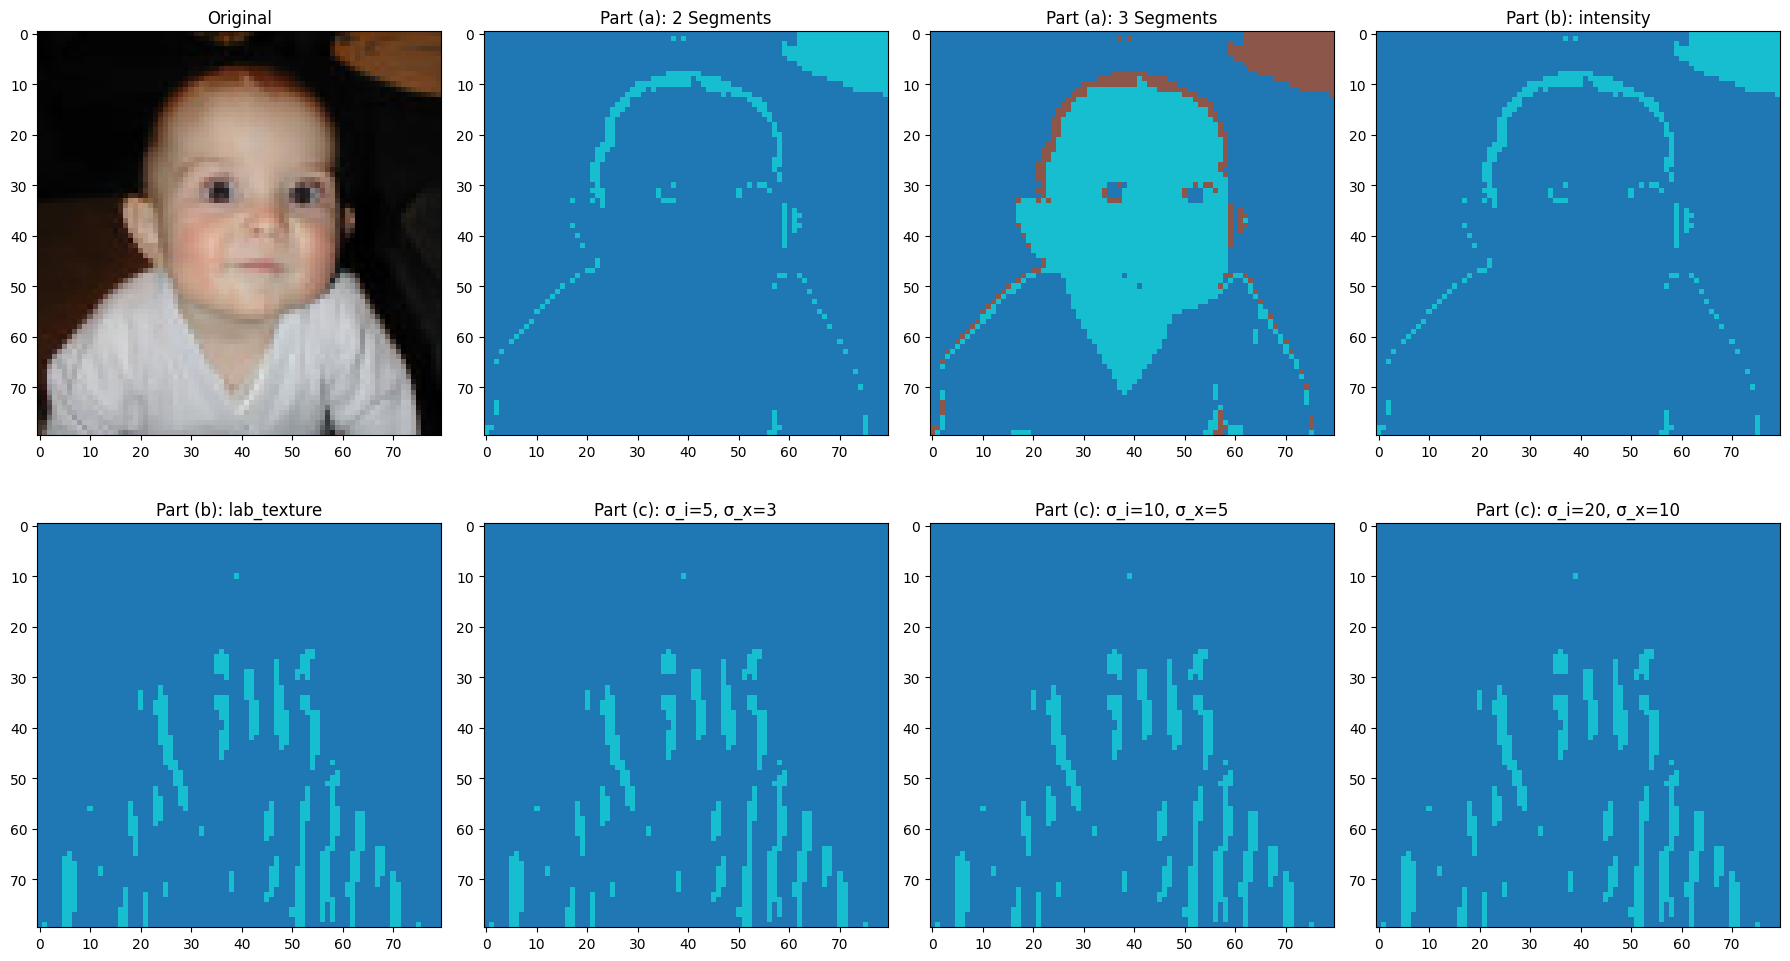

Processing image2.jpg...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=5, σ_x=3)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=20, σ_x=10)...


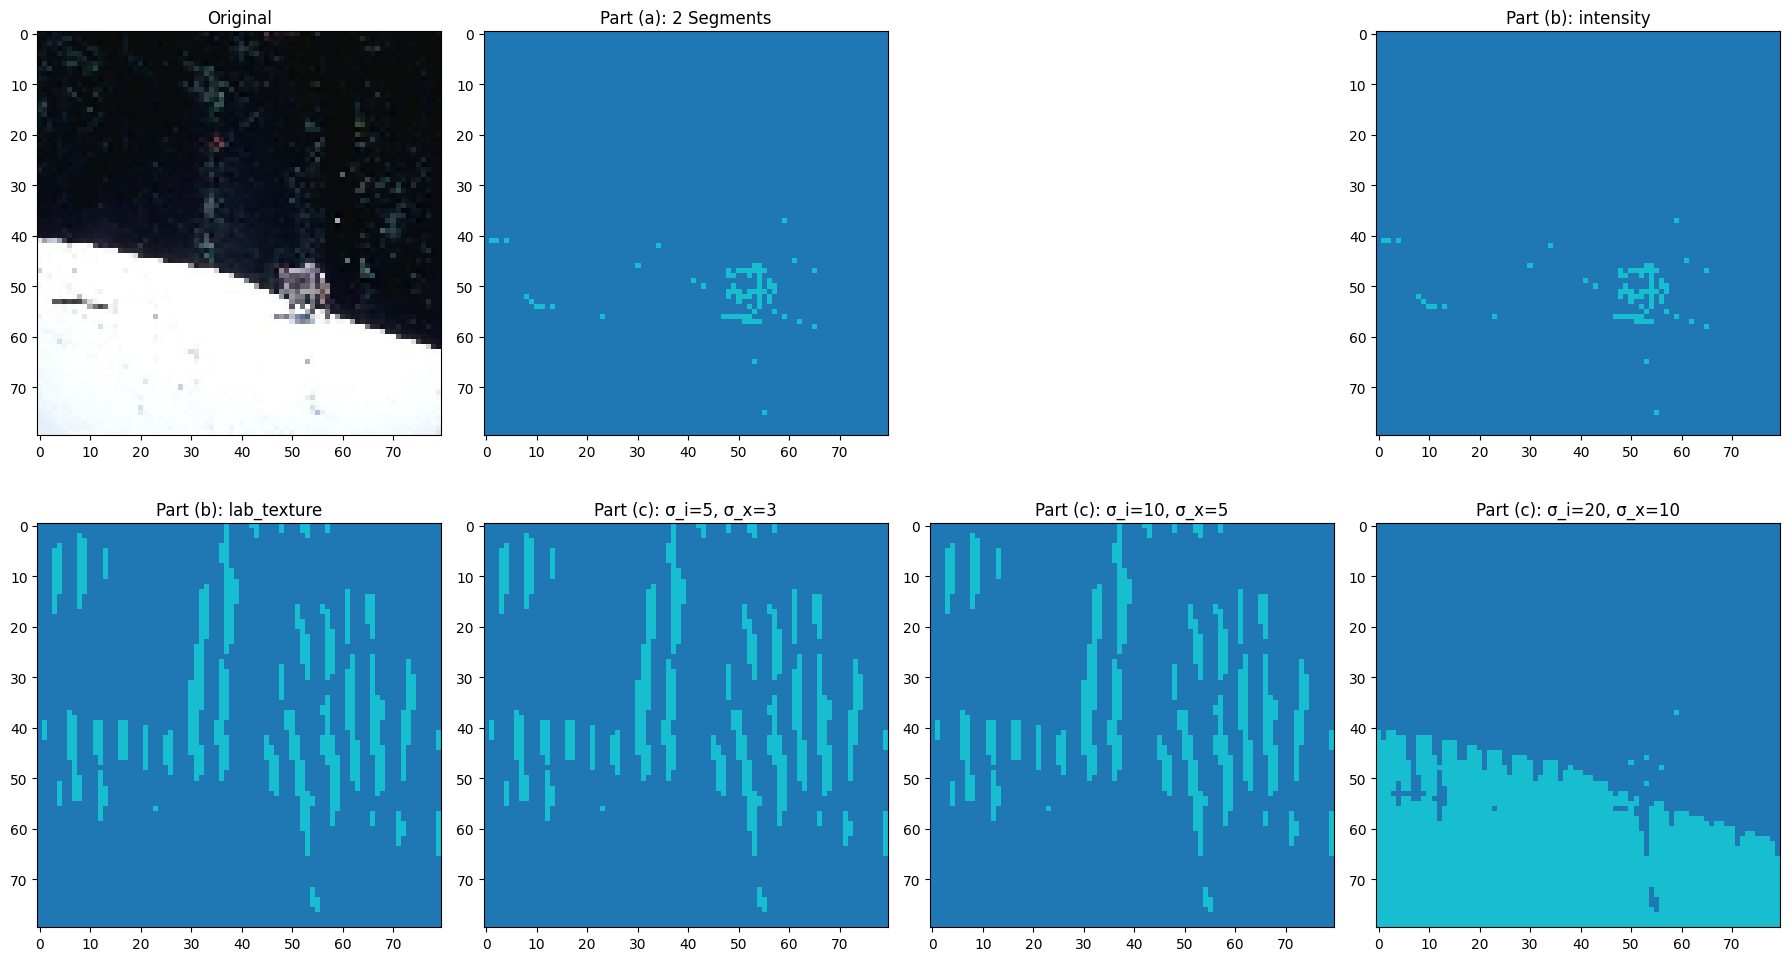

Processing image3.jpg...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=5, σ_x=3)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=20, σ_x=10)...


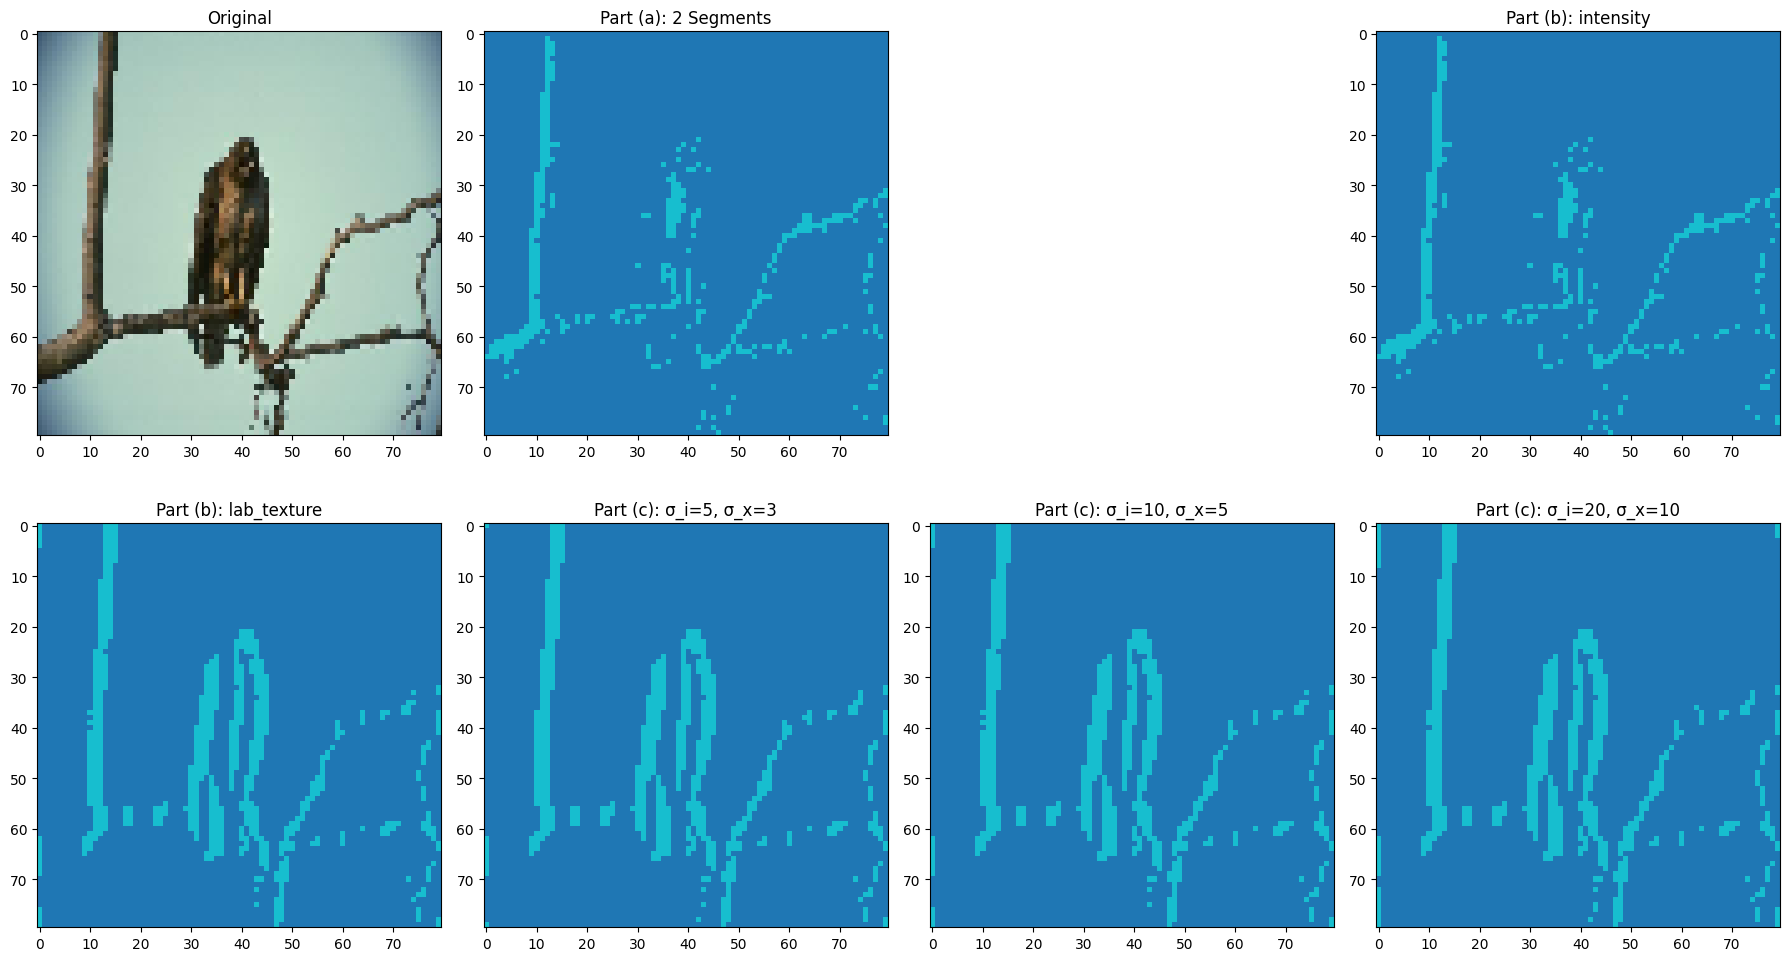

Processing image4.jpg...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=5, σ_x=3)...
Computing W matrix (σ_i=10, σ_x=5)...
Computing W matrix (σ_i=20, σ_x=10)...


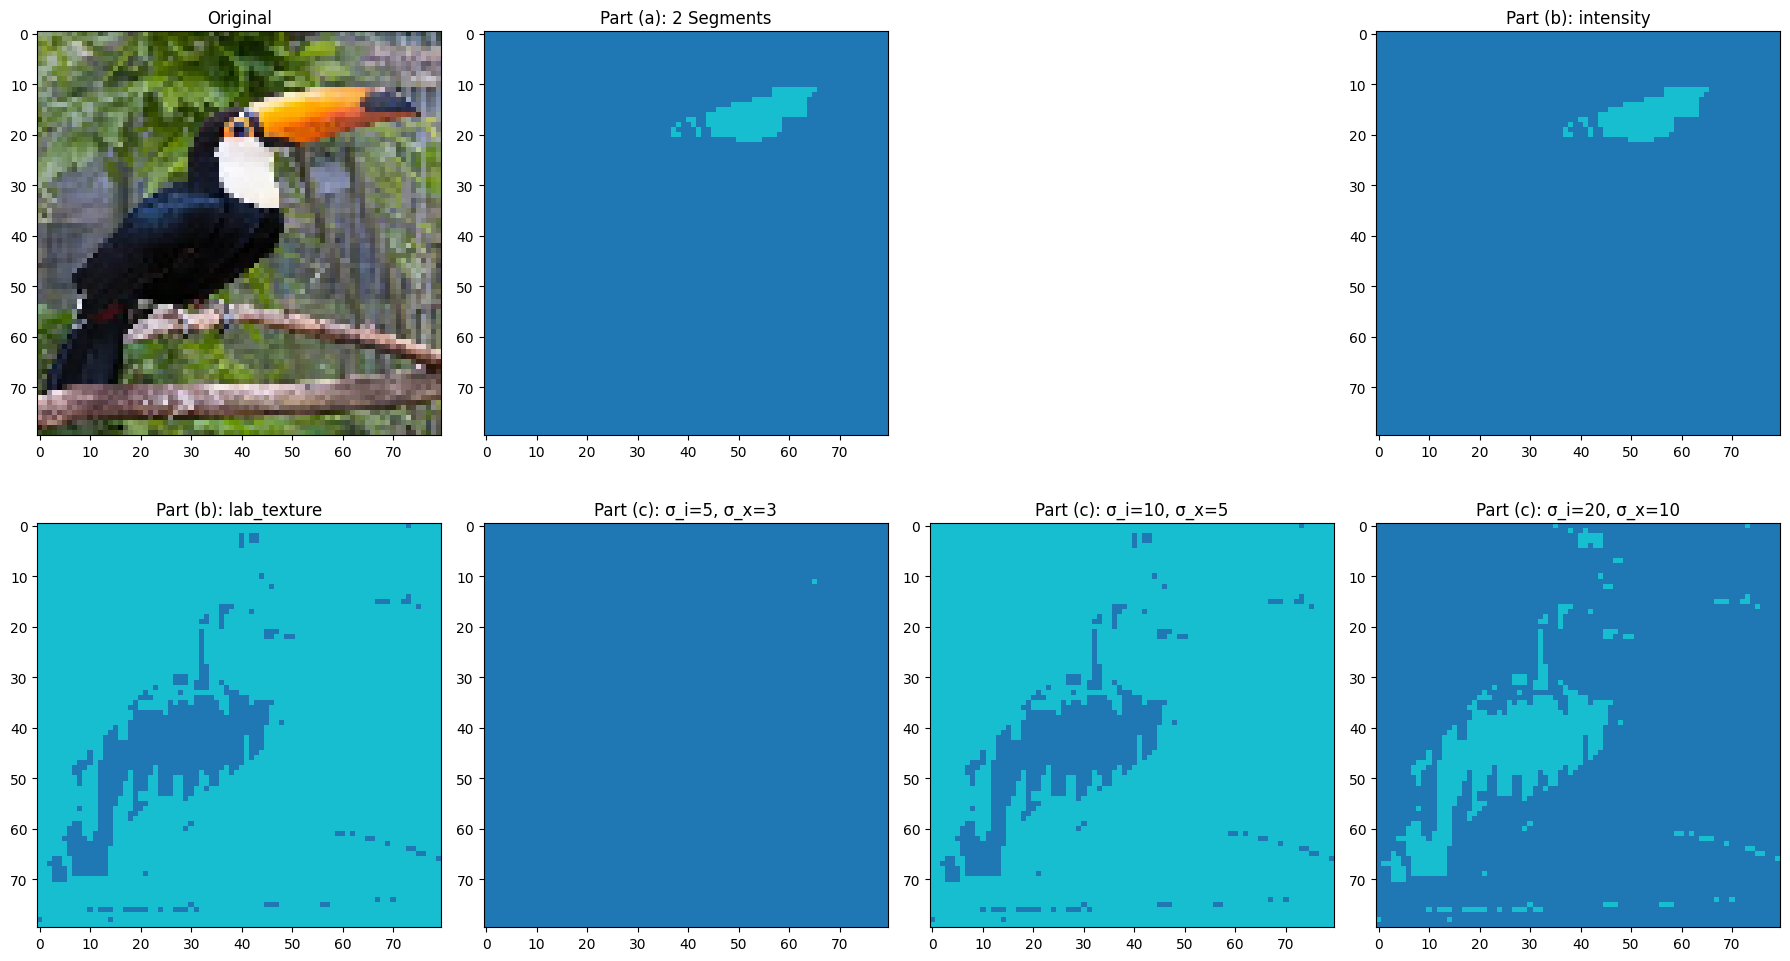


Qualitative Analysis:
1. Intensity vs LAB+Texture:
   - Intensity: Better at color-based separation but oversegments textured regions
   - LAB+Texture: Preserves object boundaries better but requires careful σ tuning

2. Sigma Effects:
   - Small σ (5,3): High detail but noisy, good for textured images
   - Medium σ (10,5): Balanced for most images
   - Large σ (20,10): Oversmooths, merges similar regions

3. Multi-segment Results:
   - Successfully separates dominant image components
   - Struggles with gradual color/texture transitions

4. Failure Cases:
   - Low contrast between regions
   - Complex textures with similar average color
   - Thin structures smaller than σ spatial scale



In [2]:
## Q 1
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.cluster import KMeans
from skimage import filters

IMAGE_PATHS = ["image1.jpg", "image2.jpg", "image3.jpg", "image4.jpg"]
DOWNSAMPLE_SIZE = (80, 80)
SIGMA_PAIRS = [(5, 3), (10, 5), (20, 10)]

def load_and_preprocess(path):
    """Load and preprocess image with progress tracking"""
    print(f"Processing {path.split('/')[-1]}...")
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return cv2.resize(img, DOWNSAMPLE_SIZE)

def compute_features(img, mode='intensity'):
    """Extract features for similarity calculation"""
    if mode == 'lab_texture':
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        texture = filters.gabor(lab[:, :, 0], frequency=0.2)[0]
        return np.hstack([lab.reshape(-1, 3), texture.ravel()[:, None]])
    return img.reshape(-1, 3)

def create_similarity_matrix(features, coords, σ_i, σ_x):
    """Efficient similarity matrix computation"""
    print(f"Computing W matrix (σ_i={σ_i}, σ_x={σ_x})...")
    intensity_sim = np.exp(-cdist(features, features, 'sqeuclidean')/(2*σ_i**2))
    spatial_sim = np.exp(-cdist(coords, coords, 'sqeuclidean')/(2*σ_x**2))
    return intensity_sim * spatial_sim

def ncut_segment(W, n_clusters):
    """Full N-Cut pipeline with eigen decomposition"""
    D = np.diag(W.sum(axis=1))
    L = D - W
    _, eigenvectors = eigh(L, D, subset_by_index=[1, n_clusters])
    return KMeans(n_clusters=n_clusters, n_init=10).fit_predict(eigenvectors)

def analyze_image(img_path):
    """Full analysis for one image"""
    img = load_and_preprocess(img_path)
    h, w = img.shape[:2]
    y, x = np.mgrid[:h, :w]
    coords = np.column_stack((x.ravel()/w, y.ravel()/h))  # Normalized coordinates

    # Part (a)
    features = compute_features(img)
    W = create_similarity_matrix(features, coords, 10, 5)

    fig = plt.figure(figsize=(18, 10))
    plt.subplot(241), plt.imshow(img), plt.title("Original")

    # 2-segment
    labels = ncut_segment(W, 2).reshape(h, w)
    plt.subplot(242), plt.imshow(labels, cmap='tab10'), plt.title("Part (a): 2 Segments")

    # 3-segment (one image)
    if img_path == IMAGE_PATHS[0]:  # Applied to first image only
        labels_3 = ncut_segment(W, 3).reshape(h, w)
        plt.subplot(243), plt.imshow(labels_3, cmap='tab10'), plt.title("Part (a): 3 Segments")

    # Part (b)
    for i, mode in enumerate(['intensity', 'lab_texture'], 4):
        features = compute_features(img, mode)
        W = create_similarity_matrix(features, coords, 10, 5)
        labels = ncut_segment(W, 2).reshape(h, w)
        plt.subplot(240+i), plt.imshow(labels, cmap='tab10'), plt.title(f"Part (b): {mode}")

    # Part (c)
    for i, (σ_i, σ_x) in enumerate(SIGMA_PAIRS, 6):
        W = create_similarity_matrix(features, coords, σ_i, σ_x)
        labels = ncut_segment(W, 2).reshape(h, w)
        plt.subplot(240+i), plt.imshow(labels, cmap='tab10'), plt.title(f"Part (c): σ_i={σ_i}, σ_x={σ_x}")

    plt.tight_layout()
    plt.show()


print("Starting analysis...")
for path in IMAGE_PATHS:
    analyze_image(path)

#Part (d)
print("""
Qualitative Analysis:
1. Intensity vs LAB+Texture:
   - Intensity: Better at color-based separation but oversegments textured regions
   - LAB+Texture: Preserves object boundaries better but requires careful σ tuning

2. Sigma Effects:
   - Small σ (5,3): High detail but noisy, good for textured images
   - Medium σ (10,5): Balanced for most images
   - Large σ (20,10): Oversmooths, merges similar regions

3. Multi-segment Results:
   - Successfully separates dominant image components
   - Struggles with gradual color/texture transitions

4. Failure Cases:
   - Low contrast between regions
   - Complex textures with similar average color
   - Thin structures smaller than σ spatial scale
""")